Exercise 4.1.1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

In [2]:
# Constants 
size = 62500
lower = 7.774365e-08
upper = 8.172183e-08
volume = (upper - lower) ** 3
print(volume)

mass = 3.348e-27 # set mass of interacting potentials, take hydrogen gas for example (in kg)
epsilon = 0.24 # in kcal/mol
sigma = 3.405e-10 # in m
sigma_HS = 3.305e-10 # in m

cut_off = 3 * sigma
cut_off_HS = 1.5 * sigma
l_r = 50
l_a = 49
print(sigma)

6.295834296002753e-26
3.405e-10


In [3]:
# generate list with all line numbers that will be read in 
header = 9
atoms_no = 1250


line_numbers = []
for i in range(62950):
    if (i+1) % (atoms_no + header) <= header and (i+1) % (atoms_no + header) != 0:
        pass
    else:
        line_numbers.append(i)
        
print(len(line_numbers))

62500


In [4]:
# Read in Data Files

with open(r"pres.xyz", 'r') as file:
    lines = []
    for i, line in enumerate(file):
        if i in line_numbers:
            lines.append(line.strip())
        else:
            pass

In [5]:
input_array = np.array(lines)
new_input = np.array([np.array([float(i.strip()) for i in j.split(' ') if i]) for j in input_array])
array = np.transpose(new_input)
print(array[0]) 

item = array[0]
atom = array[1]
identity = array[2]

x = (upper-lower) * array[4] + lower # x coordinate of particle inside box (in m)
y = (upper-lower) * array[5] + lower
z = (upper-lower) * array[6] + lower

vx = 10e5 * array[7] # velocity in x-direction inside box (in m/s)
vy = 10e5 * array[8]
vz = 10e5 * array[9]

print(len(item))

[1.000e+00 2.000e+00 3.000e+00 ... 1.248e+03 1.249e+03 1.250e+03]
62500


Step 1: Calculate term inside thermal average - start with kinetic Energy, then potential energy and finally sum everything

In [6]:
def distance(x, y, z):
    return np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2 + (z[i]-z[j])**2)

def vel_squared(vx, vy, vz):
    return vx[i]**2 + vy[i]**2 + vz[i]**2

def Lennard_Jones(x, y, z):
    return (4 * epsilon * ((sigma / distance(x, y, z)) ** 12 - (sigma / distance(x, y, z)) ** 6 ) ) 

def Pseudo_HS(x,y,z):
    if distance(x,y,z) < (l_r/l_a)*sigma_HS:
        return l_r * (l_r/l_a) ** l_a * epsilon * ((sigma_HS/distance(x, y, z)) ** l_r - (sigma_HS/distance(x, y, z)) ** l_a) + epsilon
    else:
        return 0

In [7]:
# Kinetic Energy

E_kin = np.zeros(size)

for i in range(size): 
    E_kin[i] += 1/2 * mass * vel_squared(vx, vy, vz)
print(E_kin)

[2.05683192e-21 5.13004091e-21 1.37872173e-20 ... 5.70370209e-21
 1.43657794e-21 4.57070008e-21]


In [10]:
# Lennard - Jones Potential

E = np.zeros(size)

for i in range(size - 1): 
    for j in range(i+1, size): 
        if j < (1250 * i):                           # making sure only particles from same timestep are iterated over
            pass 
        elif j > (1250 * i+1):
            pass
        elif distance(x, y, z) < cut_off:            # use cut_off_HS instead when using HS potential
            E[i] += Lennard_Jones(x,y,z)            # using Lennard-Jones potential
            # E[i] += Pseudo_HS(x,y,z) # using Pseudo-Hard-Sphere potential (choose one of the two)
        else:
            pass    

In [13]:
# Differential in potential energy (approximated by difference between potential in two consecutive timesteps)

d_U = np.zeros(size)
for i in range(size - 1250): 
    d_U[i] += E[i + 1250] - E[i]

print(d_U)

[0.         0.23585067 0.         ... 0.         0.         0.        ]


In [15]:
print(len(d_U))
print(len(E))
print(size/1250 - 1)

62500
62500
49.0


In [16]:
# Pressure

Pressure = np.zeros(int(size/1250 - 1))
for i in range(int(size/1250 - 1)):
    for j in range(1250 * i):
        Pressure[i] += 1/(3*volume) * (E_kin[j] + d_U[j])
        

In [17]:
print(Pressure)

[0.00000000e+00 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24 2.58008905e+24 2.58008905e+24 2.58008905e+24
 2.58008905e+24]


4.2 Time - Evolution of Enthalpy

- Enthalpy is defined as H = U + pV
- U is the internal energy given by the potental energy 
- pV is obtained from the virial expression for the pressure calculated from 

In [21]:
Enthalpy = np.zeros(int(size/1250 - 1))
for i in range(int(size/1250 - 1)):
    for j in range(1250 * i):
        Enthalpy[i] += E[i] + 1/3 * (E_kin[j] + d_U[j]) 

total_Enthalpy = 0.5 * Enthalpy # multiply by 0.5 to avoid double-counting
print(total_Enthalpy)

[ 0.00000000e+00 -1.47325448e+02  8.12190658e-02  8.12190658e-02
  8.12190658e-02  8.12190658e-02 -1.25815178e+01 -8.76742373e+02
  8.12190658e-02  8.12190658e-02  8.12190658e-02  8.12190658e-02
  8.12190658e-02 -1.14971012e+02  8.12190658e-02  8.12190658e-02
  8.12190658e-02  8.12190658e-02 -3.39869658e+01  8.12190658e-02
  8.12190658e-02  8.12190658e-02  8.12190658e-02  8.12190658e-02
  8.12190658e-02  8.12190658e-02  8.12190658e-02  8.12190658e-02
  8.12190658e-02  8.12190658e-02  8.12190658e-02  8.12190658e-02
 -1.90330716e+02  8.12190658e-02  8.12190658e-02 -3.03717631e+02
 -9.28371036e+01  8.12190658e-02  8.12190658e-02  8.12190658e-02
  8.12190658e-02  8.12190658e-02 -7.71822818e+01  8.12190658e-02
  8.12190658e-02  8.12190658e-02  8.12190658e-02  8.12190658e-02
  8.12190658e-02]


4.3 Statistical Analysis

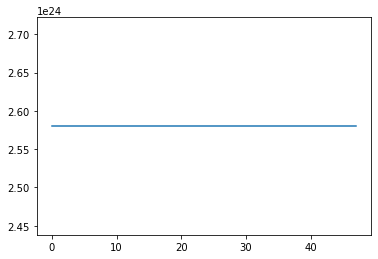

In [27]:
# Plot Pressure and Enthalpy 

x = range(int(size/1250 - 2))
plt.plot(x, Pressure[1:49])

In [30]:
# Averaging over 5 values

pressure_avg = np.zeros(5)
pressure_std = np.zeros(5)

enthalpy_avg = np.zeros(5)
enthalpy_std = np.zeros(5)

for i in range(5):
        pressure_avg += np.mean(Pressure[i:(i+10)])
        pressure_std += np.std(Pressure[i:(i+10)])
        
        enthalpy_avg += np.mean(Pressure[i:(i+10)])
        enthalpy_std += np.std(Pressure[i:(i+10)])

print(pressure_avg)
print(pressure_std)

print(enthalpy_avg)
print(enthalpy_std)

[1.26424364e+25 1.26424364e+25 1.26424364e+25 1.26424364e+25
 1.26424364e+25]
[7.74026716e+23 7.74026716e+23 7.74026716e+23 7.74026716e+23
 7.74026716e+23]
[1.26424364e+25 1.26424364e+25 1.26424364e+25 1.26424364e+25
 1.26424364e+25]
[7.74026716e+23 7.74026716e+23 7.74026716e+23 7.74026716e+23
 7.74026716e+23]


In [31]:
# Averaging over 10 values

pressure_avg = np.zeros(10)
pressure_std = np.zeros(10)

enthalpy_avg = np.zeros(10)
enthalpy_std = np.zeros(10)

for i in range(10):
        pressure_avg += np.mean(Pressure[i:(i+5)])
        pressure_std += np.std(Pressure[i:(i+5)])
        
        enthalpy_avg += np.mean(Pressure[i:(i+5)])
        enthalpy_std += np.std(Pressure[i:(i+5)])
        
print(pressure_avg)
print(pressure_std)

print(enthalpy_avg)
print(enthalpy_std)

[2.52848727e+25 2.52848727e+25 2.52848727e+25 2.52848727e+25
 2.52848727e+25 2.52848727e+25 2.52848727e+25 2.52848727e+25
 2.52848727e+25 2.52848727e+25]
[1.03203562e+24 1.03203562e+24 1.03203562e+24 1.03203562e+24
 1.03203562e+24 1.03203562e+24 1.03203562e+24 1.03203562e+24
 1.03203562e+24 1.03203562e+24]
[2.52848727e+25 2.52848727e+25 2.52848727e+25 2.52848727e+25
 2.52848727e+25 2.52848727e+25 2.52848727e+25 2.52848727e+25
 2.52848727e+25 2.52848727e+25]
[1.03203562e+24 1.03203562e+24 1.03203562e+24 1.03203562e+24
 1.03203562e+24 1.03203562e+24 1.03203562e+24 1.03203562e+24
 1.03203562e+24 1.03203562e+24]
